<a href="https://colab.research.google.com/github/maryambahri/IE7500/blob/main/scripts/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Exploratory Data Analysis (EDA)</strong></h2>
  <p style="color:#333333;">Data and distribution Exploration</p>
</div>

## Objective of This Notebook

This notebook begins by performing exploratory data analysis (EDA) on the Sentiment140 dataset to gain key insights into:

- The distribution of sentiment labels and their balance  
- The structure and length of tweets  
- The presence of mentions, hashtags, emojis, and special characters  
- How tweet characteristics vary across sentiment classes  

These findings will inform preprocessing decisions and help tailor feature extraction techniques for each model type (TF-IDF + Logistic Regression, BiLSTM, and DistilBERT). The goal is to ensure that the models are not only accurate but also resilient to the quirks of real-world tweets in sentiment-sensitive domains like finance, customer feedback, and public opinion monitoring.

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Overview</strong></h2>
  <p style="color:#333333;">Import Sentiment140 dataset and display basic information (shape, preview of data, null values, column types, etc).</p>
</div>


In [ ]:
#Note: After first time installation we should restart the kernel

import sys
!{sys.executable} -m pip install -r "../requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 56.2 MB/s eta 0:00:00m eta 0:00:010:00:01


In [ ]:
# importing all libraries here
import gdown
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html

The original dataset is available on Kaggle [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download). Since the dataset is approximately 239MB, we host it on Google Drive to simplify access and avoid GitHub’s file size limitations (maximum 100MB) for version-controlled repositories.

We use the `gdown` library to programmatically download the dataset into the local environment.

In [ ]:
# Load the raw dataset
os.makedirs("../data", exist_ok=True)

url = f"https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=d2eb6078-556b-403d-b3cd-90596499f904
To: /Users/ariesslin/northeastern_projects/ie7500/project/ie7500-g1-tweet-sentiment-nlp/data/sentiment140.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239M/239M [00:04<00:00, 50.4MB/s]


'../data/sentiment140.csv'

In [ ]:
# Naming columns for readability
columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

df = pd.read_csv(
    "../data/sentiment140.csv",
    encoding='latin-1',
    header=None,
    names=columns
)

In [ ]:
# Show first 5 rows
df.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# Summary statistics for numeric columns
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [ ]:
df['target'].unique()

array([0, 4])

### Dataset Overview and Initial Insights

**From `df.info()`:**
- The dataset contains **1,600,000 entries** and **6 columns**: `target`, `id`, `date`, `flag`, `user`, and `text`.
- **No missing values** in any column which indicates good structural integrity.
- **Data types**:
  - `target` and `id`: `int64`
  - `date`, `flag`, `user`, `text`: `object` (which are likely strings)

---

**From `df.describe()`:**

- **`target`**:
  - Range: 0 to 4
  - Mean = 2.0, Std = 2.0 → appears fairly balanced, but needs verification with `value_counts()`.

- **`id`**:
  - Large numeric values, probably unique identifiers (e.g., tweet IDs).
  - Not useful for prediction but useful for indexing or referencing.

---

### Initial Findings Summary

- Data integrity looks solid — **no nulls**, appropriate dtypes.
- `target` is the label column, we will need to examine and check class balance. It only contains **0 (negative)** and **4 (positive)** labels. Although the original Sentiment140 dataset defines a third class (2 = neutral), it is **not present in this version**, making this a **binary classification task**.
- The `id` column contains unique identifiers for each tweet. While useful for referencing individual entries, it is **not relevant to sentiment prediction** and can be safely dropped during data processing.
- Since all `id` values are unique, we can **confidently conclude there are no duplicate tweets**, at least in terms of tweet identity.


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. EDA Deep Dives into distributions</strong></h2>
  <p style="color:#333333;">Analyze class distribution, tweet length, temporal trends, and tweet content structure</p>
</div>


In [ ]:
# Define a custom color palette for sentiment classes:
# 0 = Negative → Soft red-orange (#fc8d62)
# 4 = Positive → Muted teal green (#66c2a5)
# (Optional future: 2 = Neutral → Light blue-gray, e.g., #8da0cb)
sentiment_palette = {
    0: '#fc8d62',  # Negative sentiment
    4: '#66c2a5'   # Positive sentiment
}

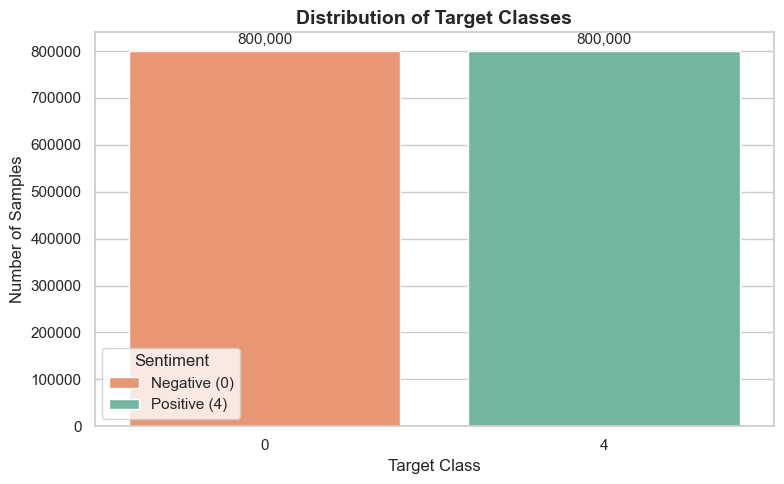

In [ ]:
# we now start visualizing the distributions of the target

# Set a clean visual style
sns.set(style="whitegrid")

# Calculate value counts
target_counts = df['target'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette=sentiment_palette, legend=True)

# Add value labels on bars
for i, value in enumerate(target_counts.values):
    plt.text(i, value + max(target_counts.values)*0.01, f'{value:,}',
             ha='center', va='bottom', fontsize=11)

# Titles and labels
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Customize the legend labels
# Get the legend object
handles, labels = barplot.get_legend_handles_labels()

# Create a dictionary to map old labels (0, 4) to new labels ('Negative', 'Positive')
new_labels = {'0': 'Negative (0)', '4': 'Positive (4)'}

# Update the labels in the legend
updated_labels = [new_labels[label] for label in labels]
barplot.legend(handles, updated_labels, title="Sentiment")

plt.show()

#### Bar Chart Distribution Insight:

Despite the Kaggle description suggesting that the dataset includes three sentiment classes (positive, negative, and neutral), this chart reveals that the annotations are limited to only two classes:

0: Negative sentiment

4: Positive sentiment

There are no neutral (class 2) samples present in this dataset.
Additionally, the distribution appears to be perfectly balanced, with approximately 800,000 samples in each class. This is ideal for training a binary classifier, as it minimizes issues related to class imbalance.

### Temporal Trends Analysis

In [ ]:
# Remove timezone string (e.g., "PDT") to avoid parsing issues
df['date'] = df['date'].str.replace(r' [A-Z]{3} ', ' ', regex=True)

# Fix and convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create a new column for year
df['year'] = df['date'].dt.year

df.head()

,target,id,date,flag,user,text,year
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009


In [ ]:
df['year'].unique()

array([2009], dtype=int32)

This indicates that all tweets in the dataset are from 2009

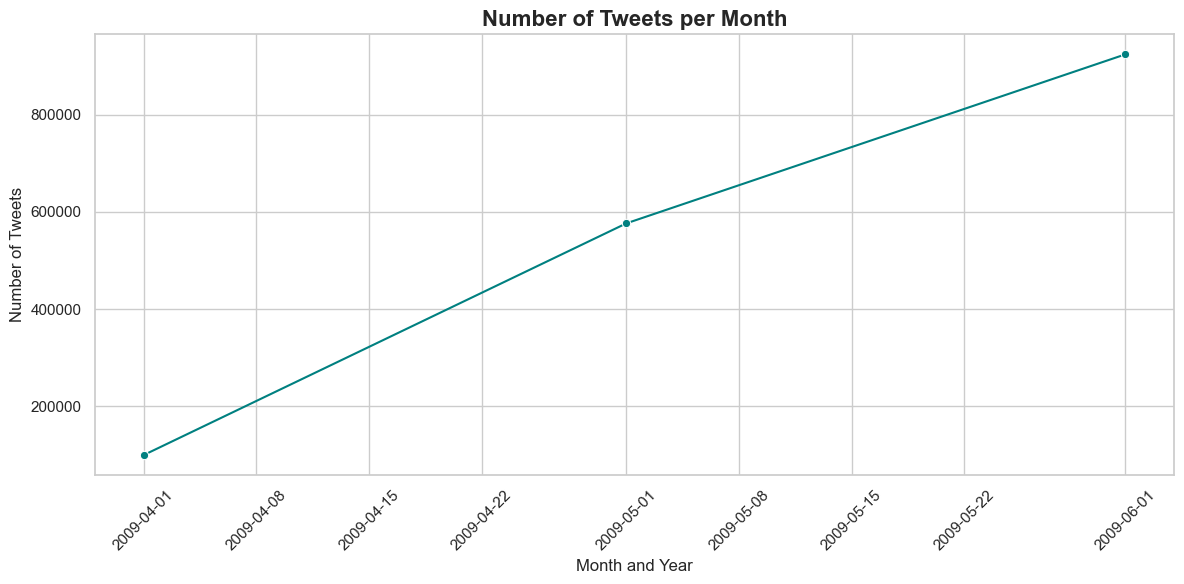

In [ ]:
# We now examine the number of tweet samples we have by month and year

# Create the 'year_month' column
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Group by year_month and count tweets
monthly_counts = df.groupby('year_month').size().reset_index(name='tweet_count')

# Set style
sns.set(style='whitegrid')

# Convert year_month to datetime for proper ordering in the x-axis
monthly_counts['year_month'] = pd.to_datetime(monthly_counts['year_month'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='tweet_count', marker='o', color='teal')

# Labels and title
plt.title("Number of Tweets per Month", fontsize=16, fontweight='bold')
plt.xlabel("Month and Year", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Line Plot Insight for Tweet Volume Over Time

This line chart shows the number of tweets collected over time based on the Sentiment140 dataset.

From the visualization, we observe that the tweets were collected over a short time span — specifically over a period of **approximately three months in 2009**.

- The dataset begins in **April 2009** and ends by **early June 2009**, suggesting a **single batch collection** during that year.
- The dataset spans only a short period (April–June 2009), so **any temporal or trend-based analysis (e.g., changes in sentiment over time) should be interpreted with caution**. Since it does not cover a full year or multiple time periods, apparent trends may reflect sampling patterns rather than true sentiment shifts.
- We observe a steady increase in tweet volume over time, which likely reflects the organic growth of Twitter’s user base during its early expansion phase in 2009.


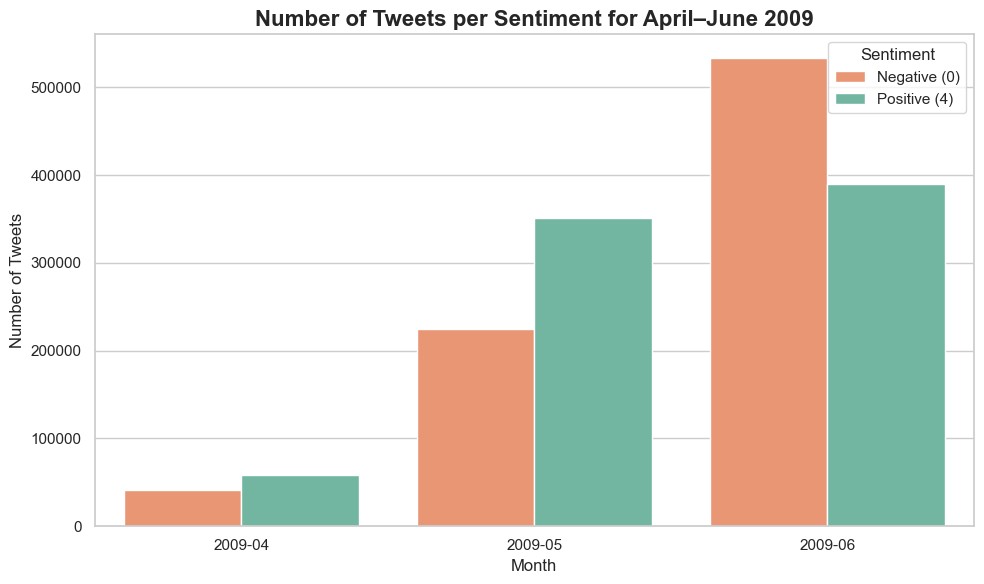

In [ ]:
# Examine tweets distribution by month

# Count tweets by month and target
monthly_sentiment_counts = (
    df.groupby(['year_month', 'target'])
    .size()
    .reset_index(name='tweet_count')
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=monthly_sentiment_counts,
    x='year_month', y='tweet_count', hue='target',
    palette=sentiment_palette
)

# Labels and title
plt.title('Number of Tweets per Sentiment for April–June 2009', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Fix legend to match colors and labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Negative (0)', 'Positive (4)'], title='Sentiment')

plt.tight_layout()
plt.show()


#### Key Insights on Number of Tweets per Sentiment for April–June 2009

This bar chart visualizes the number of tweets labeled as **negative (0)** and **positive (4)** across the three months covered by the dataset: **April, May, and June 2009**.

- Tweet volume **increased steadily each month**, peaking in June 2009.
- In **April**, tweet volume was relatively low and slightly favored **positive sentiment**.
- In **May**, the number of tweets grew substantially, with a notable rise in **positive tweets**.
- By **June**, the volume of **negative tweets** overtook positive ones, reaching the highest count in the dataset.

This temporal breakdown shows both an overall **growth in Twitter samples collected** and **variation in sentiment dynamics** during this short collection window.


### Tweet Length Analysis

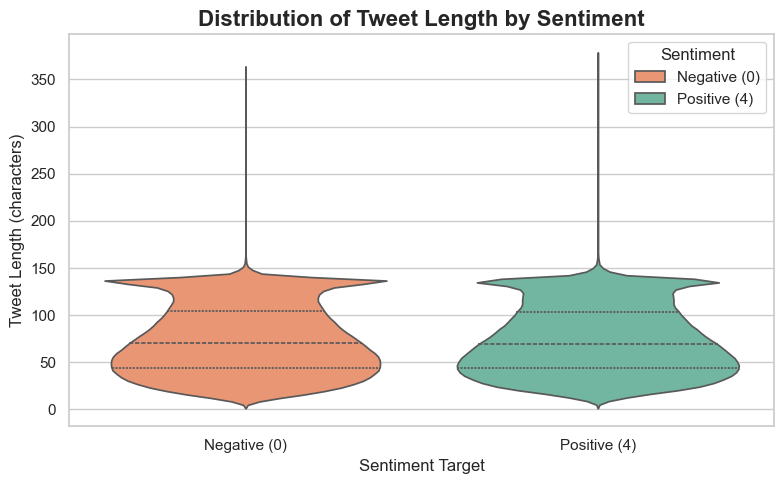

In [ ]:
# We now visualize the violin plot for each target by tweet length

# Add a new column for tweet length
df['text_length'] = df['text'].str.len()

# Violin plot of tweet length by sentiment
plt.figure(figsize=(8, 5))
ax = sns.violinplot(data=df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=True)

plt.title("Distribution of Tweet Length by Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Target", fontsize=12)
plt.ylabel("Tweet Length (characters)", fontsize=12)
plt.xticks([0, 1], ["Negative (0)", "Positive (4)"], fontsize=11)

# Fix legend to match custom labels
legend = ax.get_legend()
legend.set_title('Sentiment')
handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
label_map = {'0': 'Negative (0)', '4': 'Positive (4)'}
new_labels = [label_map.get(l, l) for l in labels]
for t, new_label in zip(legend.get_texts(), new_labels):
    t.set_text(new_label)

plt.tight_layout()
plt.show()

#### Insights on Distribution of Tweet Length by Sentiment

This violin plot illustrates the distribution of tweet lengths (in characters) for each sentiment class in the dataset:

- **Negative tweets (target = 0)**  
- **Positive tweets (target = 4)**

Key observations:
- The **distribution shapes** for both sentiments are fairly similar, suggesting that tweet length is not strongly associated with sentiment polarity.
- Most tweets fall within the **50 to 120 character** range for both classes.
- There are a few **longer tweets (up to ~360 characters)**, but they are rare and do not skew the distribution significantly.
- The **thickness of the violin** indicates the density — most tweets cluster around the 40–100 character range.

Conclusion:  
Tweet length appears to have a **amost exact pattern** across both positive and negative sentiments, and is therefore unlikely to be a strong discriminative feature on its own.


#### Tweet Length Anomaly: Why Do Some Tweets Exceed 140 Characters?

According to Twitter's original design, tweets were limited to **140 characters** in 2009 — the same year the **Sentiment140 dataset** was collected. Therefore, we would expect all tweets in the dataset to adhere to this limit.

Here are several plausible explanations for why we see tweets longer than expected:

1. **Concatenated Content**:
   - Some entries might include quoted replies or accidentally merged tweets during data collection.

2. **Unremoved Artifacts**:
   - Elements like URLs, emojis, or user mentions (`@username`) could inflate character counts if not properly cleaned before measurement.

3. **Invisible Characters**:
   - Special characters such as newline characters (`\n`), Unicode symbols, or HTML entities may not be visible but still count toward `.str.len()`.

4. **Data Corruption or Preprocessing Errors**:
   - Poor delimiter handling or formatting issues during scraping could cause multiple tweets to merge into one row.


To better understand what is causing the longer tweet lengths, we inspect the first few tweets that exceed the 140-character limit:

In [ ]:
# Count how many tweets are longer than 140 characters
num_long_tweets = df[df['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 17174


In [ ]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1295281,@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =,374
1484882,@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.,369
380539,@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£à¸£à¸à¹à¸à¸£à¸² à¹à¸«à¹à¸à¸à¹à¸§à¸¢à¸à¸µà¹à¹à¸¡à¹à¸à¹à¸­à¸à¹à¸à¸à¸±à¹à¸à¹à¹à¸¥à¹à¸à¸?à¸²à¸£à¹à¸¡à¸·à¸­à¸ &quot;à¸à¹à¸²à¸à¸à¸à¸&quot; à¸?à¸±à¸à¸­à¸µà¸? à¹?à¸à¹à¸à¸µà¹à¸¡à¸²à¸à¸µà¹à¹à¸à¹à¸«à¹à¸à¹?à¸¥à¹à¸§ à¸à¸±à¸à¸à¸²à¸¡à¸²à¸? à¸à¸£à¸£à¸à¹à¸à¸µà¸¢à¸§ Green Party,359
1582941,5 days till new top gear î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?,359
650945,human shield à®à®©à¯?à®± à®à¯à®±à¯?à®¤à¯à®à®°à¯ à®à®©à¯?à®±à¯? à®®à®±à¯?à®ªà®à®¿à®¯à¯?à®®à¯? à®à®à®à®à¯?à®à®³à®¿à®²à¯? (à®®à¯à®±à¯?à®à¯? à®µà®à¯?à®à®®à¯?) à®¤à¯à®à®°à¯?à®ªà®¾à® à®ªà®¾à®°à¯?à®¤à¯?à®¤ à®ªà¯à®¤à¯? à®à®´à¯?à®¨à¯?à®¤ à®à®£à®°à¯?à®µà®¿à®±à¯?à®à¯? à®ªà¯à®¯à®°à¯? à®à¯à®²à¯?à®² à®¤à¯à®°à®¿à®¯à®µà®¿à®²à¯?à®²à¯,348
1450935,@KaewGB à¸­à¹à¸­ à¹à¸à¸¢à¸à¸²à¸¡à¹à¹à¸à¸à¸µà¹à¸«à¸¥à¸²à¸¢à¸à¸£à¸±à¹à¸ à¹à¸¡à¹à¸¡à¸µà¹à¸à¸£à¸à¸¹à¸à¸à¸£à¸°à¹à¸à¹à¸à¸à¸µà¹ 55 à¸¡à¸µà¹?à¸à¹ à¹à¸à¹à¸²à¹à¸à¹à¸ resource à¹à¸ KU à¸à¹à¸²à¸ à¹à¸¡à¹à¸?à¹à¹à¸¥à¹à¹à¸«à¹à¹à¸à¹à¸à¸´à¸à¸§à¹à¸² VPN à¸¢à¹à¸­à¸¡à¸²à¸à¸²à¸?à¸­à¸°à¹à¸£ =v=,328
1358216,@thanr à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸£à¸²à¸à¸²à¹à¸à¸©à¸à¸²à¸­à¸­à¸?à¸à¸£à¸±à¸ à¸®à¸²à¹ ... à¹à¸à¸£à¸²à¸°à¸§à¹à¸²à¸¡à¸±à¸à¹à¸¡à¹à¸à¸£à¸à¸£à¸²à¸à¸²à¹à¸¥à¸¢à¸à¸£à¸±à¸ ... à¸­à¸±à¸à¸à¸µà¹à¸¥à¸­à¸à¹à¸ªà¹à¸à¸à¸ªà¸­à¸à¸à¸¹à¸à¸£à¸±à¸ à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸­à¸­à¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸£à¸±à¸,326
1264121,"@msathia à®®à¯?à®¹à¯à®®à¯?, à®ªà®¯à®®à¯?à®±à¯?à®¤à¯?à®¤à¯?à®¤à¯?, à®à®¤à¯à®ªà¯?à®ªà®±à¯?à®±à®¿ à®à®à¯?à®à¯à®¯à®¾à®µà®¤à¯? à®à®´à¯?à®¤à®²à®¾à®®à®¾à®©à¯?à®©à¯? à®¯à¯à®à®©à¯, à®à®©à®¾ à®ªà¯à®¯à®°à¯? à®à®°à®¿à®¯à®¿à®²à¯?à®²à®¾à®à¯?à®à®¿ à®¯à®¾à®°à¯?à®®à¯? 2 à®µà®°à®¿ à®¤à®¾à®£à¯?à®à®®à®¾à®à¯?à®à®¾à®à¯?à®",323
1319230,@laches [æçèª å¯¦å ­ååæ¶] æè¿è·ä¸åä¸­åæå?è?å ­åï¼å°¤å ¶ææ?æ?ï¼å çºä»çç¶è¦ªä¾¿æ¯è¶ç´«é½ç¶å¹´èº«éçç§æ¸ï¼è·èè¶ç´«é½ä¸èµ·è¢«æææ¬åãä»èªªï¼ä»ç¶è¦ªå ¶å¯¦ä¸¦ä¸?ççèª?è­æ°ä¸»ï¼è ¦è¢è£¡æ´å¤çæ¯ãå ±ç¢é»¨è² æã?çææ?¨ã.. http://tr.im/ngdo,314
1397388,ê·¼ë?° ë¡ë°¥ì?´ìì¼ë ì± ìì§ê³ ë ë¤í°ì¦ ì¬ê³¼íê³ ê·¸ë¬ë ë¶ë¤ì?´ ê¼­ ê³ìê±°ë ì... hitdg@chanjin ì¿ í¤ë´ì¤ë³´ê³ ì°¬ì§ë í¸ìê¸ì?´ ë¡íë ìë ê±° ë³´ê³ ëë?ìµëë¤. ì?´ê².í¸ìì? íì?´êµ¬ë ì¤ê°?íì£ .ì  ì°¬ì§ëì?´ ì± ìì§ ì?´ì ìë¤ê³ ë³´ëë?°ì...,313


The garbled characters in tweet text column indicate encoding issues, the text was likely saved or loaded using the wrong character encoding (commonly ISO-8859-1, cp1252, or utf-16) instead of the correct one (often utf-8 for Twitter data).

To fix this issue, we adjust data loading to encorporate for such encodings, and re-run some of the EDA sections again for verification.

In [ ]:
# Step 1: Create data directory and download the file
os.makedirs("../data", exist_ok=True)

url = "https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

# Step 2: Define column names
columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

# Step 3: Load with proper encoding
df_fixed = pd.read_csv(output, encoding='latin-1', header=None, names=columns)

# Step 4: Fix any garbled characters in 'text' if needed
df_fixed["text"] = df_fixed["text"].apply(lambda x: x.encode("latin1").decode("utf-8", errors="ignore") if isinstance(x, str) else x)

# Step 5: Preview result
print(df_fixed["text"].head())

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=c713585c-48cc-4b96-acd8-9095e7b977cf
To: /Users/ariesslin/northeastern_projects/ie7500/project/ie7500-g1-tweet-sentiment-nlp/data/sentiment140.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239M/239M [00:02<00:00, 85.2MB/s]


0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1        is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
2                              @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
3                                                                        my whole body feels itchy and like its on fire 
4        @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Name: text, dtype: object


#### Text Encoding Fix and Next Cleaning Step

The tweet text has been successfully decoded from its original garbled format caused by incorrect character encoding. We used the correct `latin-1` encoding along with a decoding fix to restore readable text.

However, the text still contains **HTML-escaped characters**, such as:

- `&quot;` for double quotes `"`,  
- `&amp;` for ampersand `&`,  
- `&lt;`, `&gt;` for `<` and `>` respectively.

These are not raw special characters but **escaped entities**, which need to be decoded for clean and normalized text. This is essential for proper tokenization and accurate sentiment classification.

**for data preprocessing step step**: Use `html.unescape()` from Python’s built-in `html` module to convert all HTML entities back to their intended characters before further preprocessing.


In [ ]:
# we now decode HTML-escaped entities like &quot;, &amp;, etc.
df_fixed['text'] = df_fixed['text'].apply(lambda x: html.unescape(x) if isinstance(x, str) else x)


In [ ]:
# Count how many tweets are longer than 140 characters

df_fixed['text_length'] = df_fixed['text'].apply(len)

num_long_tweets = df_fixed[df_fixed['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [ ]:
df_fixed['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()


0

In [ ]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df_fixed.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1462693,"i am NOT liking the ""big-curly-hair-with-the-braids"" look :/ im not taking my braids out! i will just simply straighten my hair once more",138
1402277,Woke up to a storm outside...Florida gets on my nerves sometimes...the state not the lady from Good Times...except the episode when...nvm,138
1307540,"@ohmishka I thought it was such a great idea too, she said she would rather support independent artists than give her $ to big companies.",138
805844,"I like penis: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You know, it'.. http://tinyurl.com/d356b3",138
805840,"Selling DILDO in a box: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You.. http://tinyurl.com/ca2ecn",138
1111822,"http://twiturm.com/vew6 I made this mix just for fun. I used to live w/ 1 of the BCR (not as a bf) though in Lake Forest, CA. Trying ...",138
975039,"@chiropractic ha! you are my hero. weekend stats looking good over here, lots of people dreading their job come monday, searching 4 new 1",138
252190,Is finally back from London after being stuck in traffic for about 5 hours! I now have hardly any time to get work done. Long night ahead,138
626735,@brennygee Looks like the twitterverse disagrees with you I just figured my first iPod was white- I thought I'd be kicking it old school.,138
1307506,"yup its going to be @TaqiyyaLuvLa @10marion @officialTila @Tyrese4Real @Willie_Day26 @souljaboytellem and many more tonight,fun... lol jk",138


In [ ]:
pd.reset_option('display.max_colwidth')

#### Now we resume with EDA, re-iterating over some which we have already done


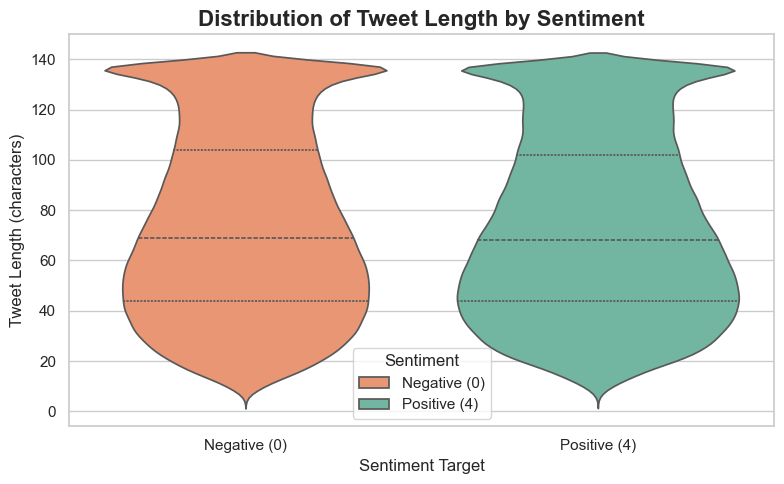

In [ ]:
# We now visualize again the violin plot for each target by tweet length

# Add a new column for tweet length
df_fixed['text_length'] = df_fixed['text'].str.len()

# Violin plot of tweet length by sentiment
plt.figure(figsize=(8, 5))
ax = sns.violinplot(data=df_fixed, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=True)

plt.title("Distribution of Tweet Length by Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Target", fontsize=12)
plt.ylabel("Tweet Length (characters)", fontsize=12)
plt.xticks([0, 1], ["Negative (0)", "Positive (4)"], fontsize=11)

# Fix legend to match custom labels
legend = ax.get_legend()
legend.set_title('Sentiment')
handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
label_map = {'0': 'Negative (0)', '4': 'Positive (4)'}
new_labels = [label_map.get(l, l) for l in labels]
for t, new_label in zip(legend.get_texts(), new_labels):
    t.set_text(new_label)

plt.tight_layout()
plt.show()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_1799/862403846.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = df_fixed.groupby(['length_bucket', 'target']).size().reset_index(name='count')


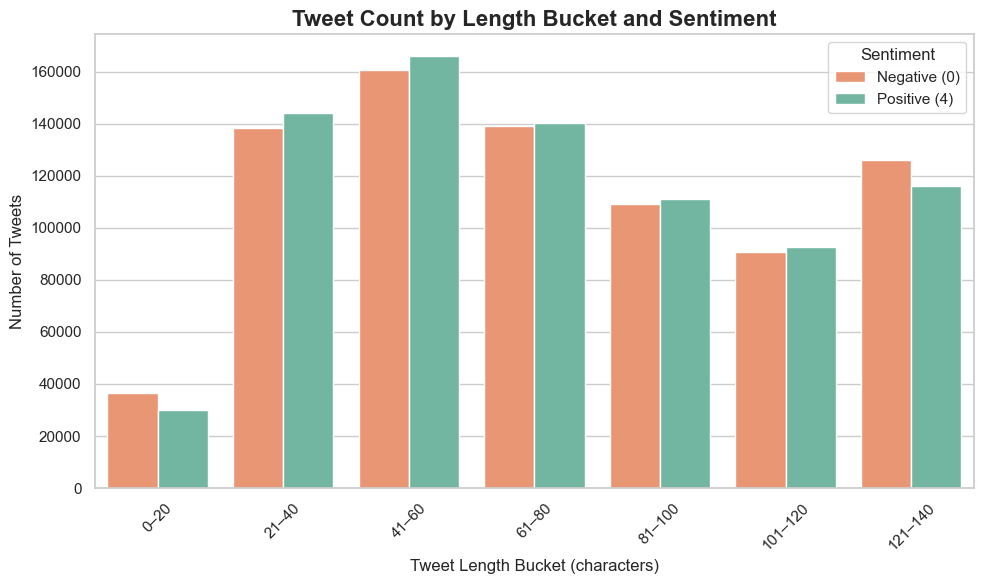

In [ ]:
# We now examine tweet length and sentiment


# Define adjusted bins based on observed distribution
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Create tweet length buckets
df_fixed['length_bucket'] = pd.cut(df_fixed['text_length'], bins=bin_edges, labels=bin_labels, right=True)

# Group by bucket and sentiment, then count
bucket_counts = df_fixed.groupby(['length_bucket', 'target']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=bucket_counts,
    x='length_bucket',
    y='count',
    hue='target',
    palette=sentiment_palette
)

# Update legend labels
label_map = {0: 'Negative (0)', 4: 'Positive (4)'}
handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(int(label), label) for label in labels]
ax.legend(handles, new_labels, title="Sentiment")

# Axis labels and formatting
plt.title("Tweet Count by Length Bucket and Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Tweet Length Bucket (characters)", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Counting the number of tweets with special characters, and those that are a response to other users

# Define a regex pattern for special characters (excluding whitespace and alphanumerics)
special_char_pattern = r"[^\w\s]"  # matches anything that's not a-z, A-Z, 0-9, or whitespace

# Count tweets that contain at least one special character
num_special_chars = df_fixed['text'].str.contains(special_char_pattern).sum()

# Count tweets that start with a mention (starts with '@')
num_mentions = df_fixed['text'].str.startswith('@').sum()

# Output
print(f"Number of tweets with special characters: {num_special_chars:,}")
print(f"Number of tweets that are mentions (start with @): {num_mentions:,}")


Number of tweets with special characters: 1,449,479
Number of tweets that are mentions (start with @): 698,079


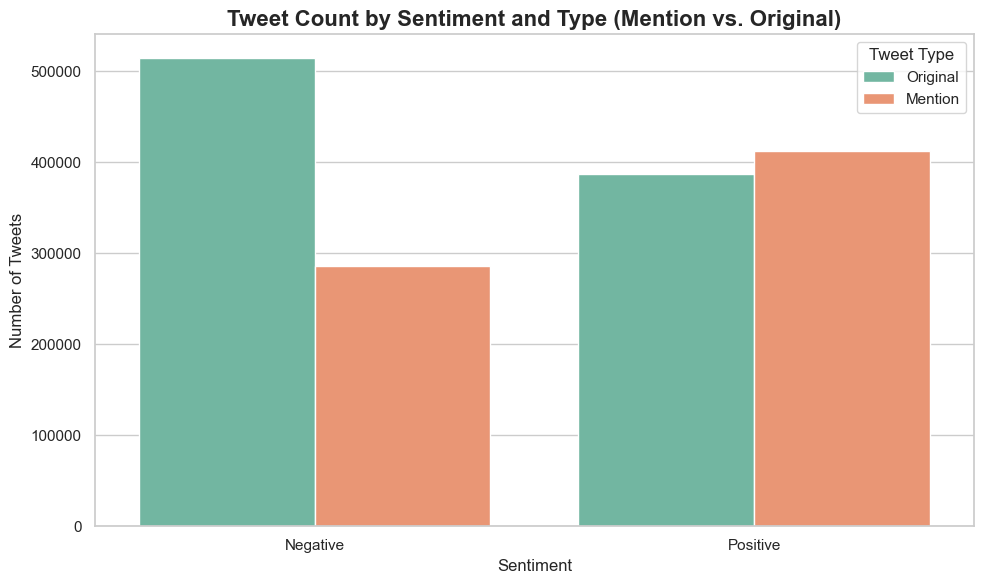

In [ ]:
# Now we examine if any pattern arises if the tweet is a response/mention or not

# Create a boolean column: True if tweet starts with '@', else False
df_fixed['is_mention'] = df_fixed['text'].str.startswith('@')

# Group by sentiment (target) and mention status
mention_sentiment_counts = (
    df_fixed.groupby(['target', 'is_mention'])
    .size()
    .reset_index(name='tweet_count')
)

import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the sentiment and mention columns
mention_sentiment_counts['Sentiment'] = mention_sentiment_counts['target'].map({0: 'Negative', 4: 'Positive'})
mention_sentiment_counts['Tweet Type'] = mention_sentiment_counts['is_mention'].map({True: 'Mention', False: 'Original'})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mention_sentiment_counts,
    x='Sentiment', y='tweet_count', hue='Tweet Type',
    palette='Set2'
)

# Labels and title
plt.title('Tweet Count by Sentiment and Type (Mention vs. Original)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(title='Tweet Type')
plt.tight_layout()
plt.show()

## General EDA Summary

- The dataset comprises **1.6 million labeled tweets**, split evenly between **positive (target = 4)** and **negative (target = 0)** sentiments.
- There are **no missing or malformed values** across any of the six columns: `target`, `id`, `date`, `flag`, `user`, and `text`. This indicates excellent data quality and readiness for downstream processing.
- The **sentiment distribution is perfectly balanced**, with approximately **800,000 samples in each class**. This lack of class imbalance is ideal for training binary classifiers without the need for resampling.
- A violin plot of tweet lengths reveals that both sentiment classes have similar distributions, with most tweets falling in the **20–70 character** range. This implies that **tweet length does not correlate strongly with sentiment**, reducing the risk of unintended bias during modeling.
- Temporal analysis shows that the tweets were collected within a short time span — from **April to June 2009**. Although there is a noticeable increase in tweet volume across these months, the **sentiment proportions remain consistent**, suggesting this variation has **minimal effect on learning or sentiment classification**.
- When breaking down tweets by **type of interaction** (original tweets vs. replies/mentions that begin with `@`), an interesting pattern emerges:
  - **Negative tweets are more likely to be original posts**, while
  - **Positive tweets are more often replies or mentions** to other accounts.
  
  This behavioral difference suggests that **positive sentiment may be more common in interpersonal or interactive tweets**, whereas **negative sentiment might be more frequently expressed in stand-alone posts**. This subtle distinction could have implications for contextual sentiment modeling.

Overall, the dataset is **clean, balanced, and well-structured**, making it a strong foundation for robust sentiment classification using classical or deep learning techniques.


## Key Note

During EDA, we observed a behavioral difference between tweet types:
- **Negative tweets are more likely to be original posts**
- **Positive tweets more frequently occur as replies or mentions (starting with `@`)**

To avoid discarding this valuable context during text preprocessing and to enhance model learning, we will not directly discard @ and lose valuable information.



## Plan to Leverage Tweet Interaction Type (Mentions vs. Original) for NLP Sentiment Classification

- Replace usernames (e.g., `@user123`) with a neutral token like `[USER]`.
- This keeps the context of interaction (e.g., replying to someone) without overfitting to specific handles.

```python
df['clean_text'] = df['text'].str.replace(r'^@\w+', 'MENTION', regex=True)
```


- Create an Explicit Feature column: is_mention

This results in capturing conversational context, which might influence sentiment.

